In [1]:
!pip3 install mtcnn

     |████████████████████████████████| 2.3MB 8.5MB/s 


In [2]:
import os
import zipfile
import random
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from mtcnn.mtcnn import MTCNN
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
local_zip= '/content/drive/MyDrive/G/Cropped images.zip'
zip_ref= zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
data_dir= Path('/tmp/Cropped images')
list_people = os.listdir(data_dir)
folder_count = len(list_people) 

In [6]:
detector  = MTCNN()

In [7]:
def get_image_pairs(data_dir):
    IMAGE_A = []
    IMAGE_B = []
    labels = []
    for i in range(folder_count):
        if list_people[i] != '.DS_Store':
            image_count = len(os.listdir(data_dir/ list_people[i]))
            for j in range(image_count):
                ind1 = np.random.randint(image_count)
                ind2 = np.random.randint(image_count)
                path_1 = os.listdir(data_dir/list_people[i])[ind1]
                path_2 = os.listdir(data_dir/list_people[i])[ind2]
                if (path_1 != '.DS_Store' and path_2 != '.DS_Store'): 
                    IMAGE_A.append(data_dir /list_people[i] /path_1)
                    IMAGE_B.append(data_dir /list_people[i] /path_2)
                    labels.append(1)
    neg = len(IMAGE_A)
    
    for i in range(neg):
        ind1 = np.random.randint(folder_count)
        ind2 = np.random.randint(folder_count)
        if (ind1 != ind2) and (list_people[ind1]!= '.DS_Store') and (list_people[ind2]!= '.DS_Store'):
            image_list_1 = os.listdir(data_dir/list_people[ind1])
            bool_1 =  True in (ele == '.DS_Store' for ele in image_list_1)
            image_list_2 = os.listdir(data_dir / list_people[ind2])
            bool_2 =  True in (ele == '.DS_Store' for ele in image_list_2)
            if bool_1 == True:
                image_list_1.remove('.DS_Store')
            if bool_2 == True:
                image_list_2.remove('.DS_Store')        
            count1 = len(image_list_1)
            count2 = len(image_list_2)
            image_ind_1 = np.random.randint(count1)
            image_ind_2 = np.random.randint(count2)
    
            IMAGE_A.append(str(data_dir/list_people[ind1]/image_list_1[image_ind_1]))
            IMAGE_B.append(str(data_dir/list_people[ind2]/image_list_2[image_ind_2]))
            labels.append(0)
    labels = np.array(labels)
    return IMAGE_A,IMAGE_B,labels

In [8]:
IMAGE_A,IMAGE_B,labels = get_image_pairs(data_dir)

In [11]:
dataset = pd.DataFrame({'IMAGE_A': IMAGE_A[:], 'IMAGE_B': IMAGE_B[:], 'LABEL':labels[:]})
dataset = dataset.sample(frac=1)
dataset.reset_index(inplace = True) 
dataset.head()

,index,IMAGE_A,IMAGE_B,LABEL
0,5235,/tmp/Cropped images/0013_0002289/0000006.jpg,/tmp/Cropped images/0006_0000601/0000011.jpg,0
1,1691,/tmp/Cropped images/0013_0002122/0000002.jpg,/tmp/Cropped images/0013_0002122/0013_0002122_...,1
2,2389,/tmp/Cropped images/0007_0001330/0000007.jpg,/tmp/Cropped images/0007_0001330/0000001.jpg,1
3,2797,/tmp/Cropped images/0013_0002213/0000004.jpg,/tmp/Cropped images/0013_0002213/0000006.jpg,1
4,8018,/tmp/Cropped images/0013_0002330/0000009.jpg,/tmp/Cropped images/0010_0001643/0000002.jpg,0


1    4355
0    4345
Name: LABEL, dtype: int64


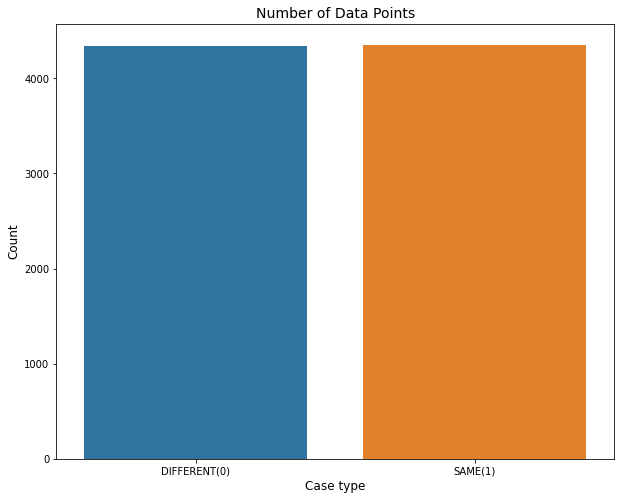

In [12]:
##THE DATA IS PERFECTLY BALANCED
cases_count = dataset['LABEL'].value_counts()
print(cases_count)

plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of Data Points', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['DIFFERENT(0)', 'SAME(1)'])
plt.show()

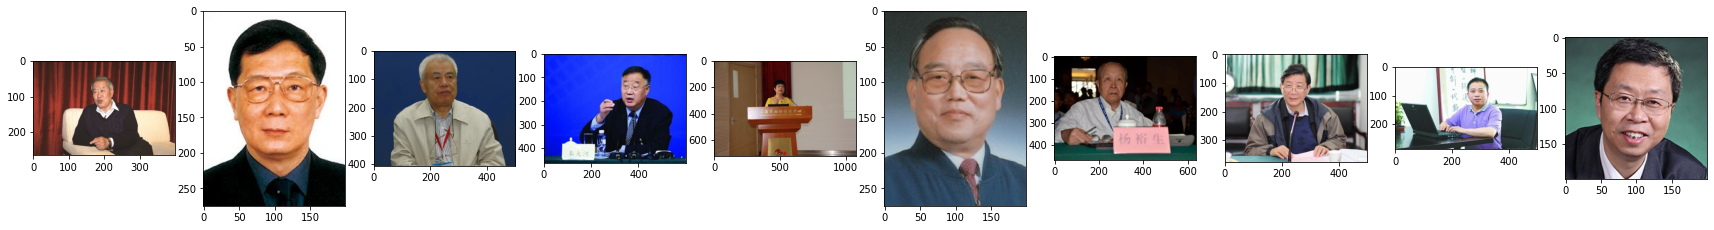

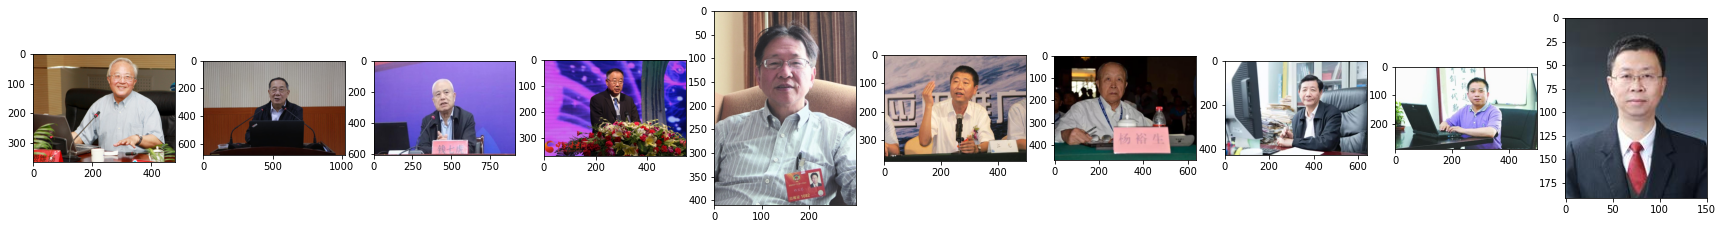

In [13]:
#VISUALIZING THE DATASET
f, ax = plt.subplots(1,10, figsize=(30,10))
for i in range(10):
  img = cv2.imread(str(dataset['IMAGE_B'][i]))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  ax[i].imshow(img) 
f, ax = plt.subplots(1,10, figsize=(30,10))
for i in range(10):
  img = cv2.imread(str(dataset['IMAGE_A'][i]))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  ax[i].imshow(img) 

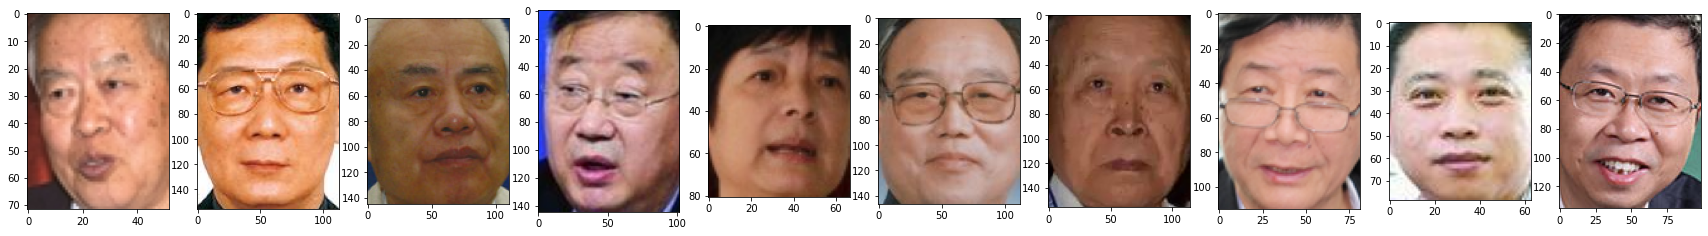

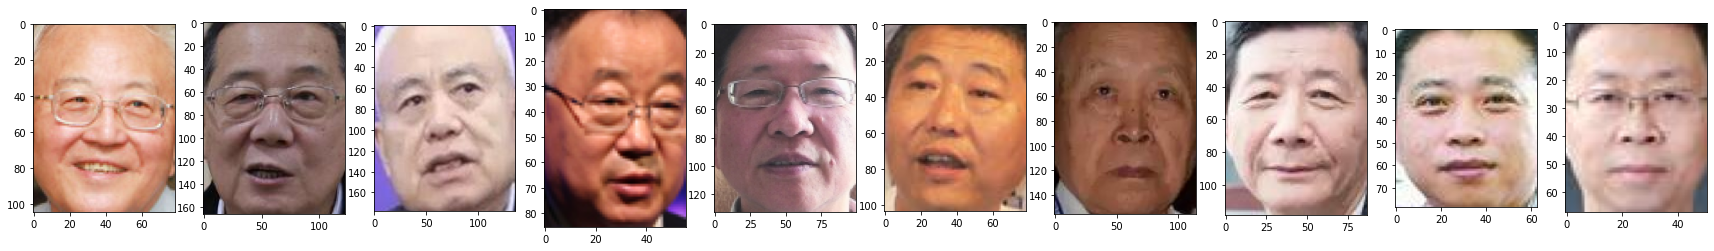

In [14]:
#EXTRACTING FACES
f, ax = plt.subplots(1,10, figsize=(30,10))
for i in range(10):
  img = cv2.imread(str(dataset['IMAGE_B'][i]))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  face_locations = detector.detect_faces(img)
  x,y,w,h = face_locations[0]['box']
  face = img[y:y+h, x:x+w] 
  ax[i].imshow(face) 
f, ax = plt.subplots(1,10, figsize=(30,10))
for i in range(10):
  img = cv2.imread(str(dataset['IMAGE_A'][i]))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  face_locations = detector.detect_faces(img)
  x,y,w,h = face_locations[0]['box']
  face = img[y:y+h, x:x+w] 
  ax[i].imshow(face) 

In [15]:
labels = dataset['LABEL']
IMAGE_A = dataset['IMAGE_A']
IMAGE_B = dataset['IMAGE_B']

In [16]:
IMG_SIZE = 80
def Generate_data(IMAGE_A,IMAGE_B,IMG_SIZE_X,IMG_SIZE_Y):
    train_data = np.zeros([len(IMAGE_A),2,IMG_SIZE_X,IMG_SIZE_Y,3])
    for index in tqdm(range(len(IMAGE_B)-1), desc = 'Extrcating Face Features...'):
        face = cv2.imread(str(IMAGE_A[index]))
        face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        face_locations = detector.detect_faces(face)
        x,y,w,h = face_locations[0]['box']
        face = face[y:y+h, x:x+w] 
        face = cv2.resize(face, (IMG_SIZE,IMG_SIZE))
        face = face/255
        train_data[index][0] = face
    
        face = cv2.imread(str(IMAGE_B[index]))
        face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        face_locations = detector.detect_faces(face)
        x,y,w,h = face_locations[0]['box']
        face = face[y:y+h,x:x+w]   
        face = cv2.resize(face, (IMG_SIZE,IMG_SIZE))
        face = face/255
        train_data[index][1] = face 
    return train_data

In [17]:
train_data = Generate_data(IMAGE_A,IMAGE_B,IMG_SIZE,IMG_SIZE)

Extrcating Face Features...: 100%|██████████| 8699/8699 [2:56:22<00:00,  1.22s/it]


In [19]:
IMAGE_A = train_data[:,0]
IMAGE_B = train_data[:,1]

In [21]:
import pickle
#Saving the data
pickle_out = open("FIRST_IMAGE.pickle","wb")
pickle.dump(IMAGE_A,pickle_out)
pickle_out.close()

In [22]:
pickle_out = open("SECOND_IMAGE.pickle","wb")
pickle.dump(IMAGE_B,pickle_out)
pickle_out.close()

In [23]:
pickle_out = open("labels.pickle","wb")
pickle.dump(labels,pickle_out)
pickle_out.close()